In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Process EMEP Hg deposition

Hans Fredrik has been sent wet and dry Hg deposition data from EMEP. The data use the new 0.1 by 0.1 degree EMEP grid, as defined [here](http://www.ceip.at/ms/ceip_home1/ceip_home/new_emep-grid/grid_definition/). Deposition is reported separately for each land use class in each grid cell, further sub-divided into "wet" and "dry". 

The table `'LandCover_NO.csv'` lists the proportions of each land cover type in each grid cell. For each land cover type, there are two further files: `'hg_dry_XXXX_NO.csv'` and `'hg_wet_XXXX_NO.csv'`, where `'XXXX'` is the land cover class. These files give the wet or dry Hg deposition to the specified land cover class in units of  g/km2/yr. 

Hans Fredrik would like a file with one row per EMEP grid cell, and two columns per land use class (one for wet deposition and one for dry). The workflow will look something like this:

 1. Calculate the area for each EMEP grid cell
 
 2. Using the areas from (1) and the proportions in `'LandCover_NO.csv'`, calculate the area of each land cover class in each grid cell
 
 3. Using `'hg_dry_XXXX_NO.csv'`, `'hg_wet_XXXX_NO.csv'` and the areas from (2), calculate wet and dry Hg deposition inputs to each land class in each grid cell
 
 4. Join the datasets together and tidy
 
**Update 02/11/2018:** The overall aim is to estimate wet, dry and total (= wet + dry) Hg deposition for each of Norway's four OSPAR regions. I have modified the code below to reflect this.
 
## 1. EMEP grid

I have downloaded a shapefile for the Norwegian portion of the 0.1 degree EMEP grid from [here](http://www.ceip.at/ms/ceip_home1/ceip_home/new_emep-grid/grid_definition/). Each cell can be uniquely identified by ('lon', 'lat') co-ordinates, which identify the centre of each cell. Furthermore, there is an `'area'` field that provides cell areas in km2 and a `'frac_area'` field that provides the areas of each cell within Norway. **I am assuming that the land cover proportion in `'LandCover_NO.csv'` area based on the `'frac_area'` field**.

**Note:** The raw shapefile includes Svalbard, which is not to be considered in this analysis. I have therefore created a new shapefile with Svalbard removed.

In [2]:
# Read shapefile
in_shp = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
          r'\data\gis\EMEP_GRID_01x01DEG_NO_minus_Svalbard.shp')
emep_gdf = gpd.read_file(in_shp)

# Rename 'long' and 'lon'
emep_gdf['lon'] = emep_gdf['long']
del emep_gdf['long']

emep_gdf.head()

,long_min,long_max,lat_min,lat_max,lat,ISO,fraction,area,frac_area,Name,Number,geometry,lon
0,6.9,7.0,57.9,58.0,57.95,NO,0.003423,65.952005,0.225781,Norway,18,"POLYGON ((7.000000000499654 57.89999999950044,...",6.95
1,7.0,7.1,57.9,58.0,57.95,NO,0.092032,65.952004,6.069710,Norway,18,"POLYGON ((7.100000000299815 57.89999999950044,...",7.05
2,7.1,7.2,57.9,58.0,57.95,NO,0.002899,65.952004,0.191206,Norway,18,"POLYGON ((7.200000000099976 57.89999999950044,...",7.15
3,7.2,7.3,57.9,58.0,57.95,NO,0.011433,65.952004,0.754015,Norway,18,"POLYGON ((7.299999999900137 57.89999999950044,...",7.25
4,7.3,7.4,57.9,58.0,57.95,NO,0.033448,65.952005,2.205934,Norway,18,"POLYGON ((7.400000000599618 57.89999999950044,...",7.35


## 2. Land cover proportions

In [3]:
# Read LC props
lc_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
           r'\data\hg_dep\LandCover_NO.csv')
lc_df = pd.read_csv(lc_path, skiprows=2, skipinitialspace=True)

# Get list of unique LC names
lc_list = list(set(lc_df.columns) - set(['i', 'j', 'lon', 'lat']))

lc_df.head()

,i,j,lon,lat,Water,EvNeedl,EvBroad,DecNeedl,DecBroad,MixedFor,...,OpenShrub,WoodSav,Savanna,Grassland,Wetland,Cropland,Urban,Crop_NatVeg,Snow_Ice,Bar_SparVeg
0,370,280,6.95,57.95,1.00000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
1,371,280,7.05,57.95,0.96710,0.025977,0.0,0.0,0.000000,0.006926,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
2,366,281,6.55,58.05,0.94967,0.019084,0.0,0.0,0.005207,0.017354,...,0.0,0.000000,0.000000,0.0,0.006946,0.00000,0.00000,0.001735,0.0,0.0
3,367,281,6.65,58.05,0.37728,0.260120,0.0,0.0,0.008682,0.284480,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0
4,368,281,6.75,58.05,0.37728,0.260120,0.0,0.0,0.008682,0.284480,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0


In [4]:
# Check that all proportions add to 1
print ('Min:', lc_df[lc_list].sum(axis=1).min())
print ('Max:', lc_df[lc_list].sum(axis=1).max())

Min: 0.9999819
Max: 1.0000149999999999


In [5]:
# Join to spatial data
emep_gdf = emep_gdf.merge(lc_df, 
                          on=['lon', 'lat'])

emep_gdf.head()

,long_min,long_max,lat_min,lat_max,lat,ISO,fraction,area,frac_area,Name,...,OpenShrub,WoodSav,Savanna,Grassland,Wetland,Cropland,Urban,Crop_NatVeg,Snow_Ice,Bar_SparVeg
0,6.9,7.0,57.9,58.0,57.95,NO,0.003423,65.952005,0.225781,Norway,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
1,7.0,7.1,57.9,58.0,57.95,NO,0.092032,65.952004,6.069710,Norway,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0
2,6.5,6.6,58.0,58.1,58.05,NO,0.018951,65.769437,1.246416,Norway,...,0.0,0.000000,0.000000,0.0,0.006946,0.00000,0.00000,0.001735,0.0,0.0
3,6.6,6.7,58.0,58.1,58.05,NO,0.259841,65.769437,17.089623,Norway,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0
4,6.7,6.8,58.0,58.1,58.05,NO,0.349332,65.769437,22.975351,Norway,...,0.0,0.017349,0.010419,0.0,0.010424,0.01562,0.00347,0.008676,0.0,0.0


## 3. Calculate land areas for each cover class

In [6]:
# Loop over classes
for lc in lc_list:
    emep_gdf['%s_km2' % lc] = emep_gdf['frac_area'] * emep_gdf[lc]

## 4. Calculate dry deposition for each land cover class in each cell

In [7]:
# Loop over classes
for lc in lc_list:
    # Read dry dep data
    dry_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
                r'\data\hg_dep\hg_dry_%s_NO.csv' % lc)
    dry_df = pd.read_csv(dry_path, skiprows=2, skipinitialspace=True)
    
    # Join
    emep_gdf = emep_gdf.merge(dry_df, 
                              on=['lon', 'lat'])
    
    # Calc flux to cell
    emep_gdf['dry_%s_g' % lc] = emep_gdf['%s_km2' % lc] * emep_gdf['dep flux']
    del emep_gdf['dep flux']    

## 5. Calculate wet deposition for each land cover class in each cell

In [8]:
# Loop over classes
for lc in lc_list:
    # Read wet dep data
    wet_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
                r'\data\hg_dep\hg_wet_%s_NO.csv' % lc)
    wet_df = pd.read_csv(wet_path, skiprows=2, skipinitialspace=True)
    
    # Join
    emep_gdf = emep_gdf.merge(wet_df, 
                              on=['lon', 'lat'])
    
    # Calc flux to cell
    emep_gdf['wet_%s_g' % lc] = emep_gdf['%s_km2' % lc] * emep_gdf['dep flux']
    del emep_gdf['dep flux']

## 6. Sum dry

In [9]:
# Sum dry dep
cols = ['dry_%s_g' % i for i in lc_list]
emep_gdf['total_dry_g'] = emep_gdf[cols].sum(axis=1)

## 7. Sum wet

In [10]:
# Sum wet dep
cols = ['wet_%s_g' % i for i in lc_list]
emep_gdf['total_wet_g'] = emep_gdf[cols].sum(axis=1)

## 8. Tidy

**Update 02/11/2018:** We're no longer interested in deposition to individual land cover classes. These have been commented out below.

In [11]:
# Get data of interest
cols = ['geometry', 'lon', 'lat', 'area', 'frac_area']

## Add cols for wet and dry dep
#for lc in lc_list:
#    cols.append('dry_%s_g' % lc)
#    cols.append('wet_%s_g' % lc)
    
# Add totals
cols.append('total_dry_g')
cols.append('total_wet_g')
    
# Extract data
emep_gdf = emep_gdf[cols]

# Overall total
emep_gdf['total_dep_g'] = emep_gdf['total_dry_g'] + emep_gdf['total_wet_g']

# Add unique index col for pts (used later)
emep_gdf.reset_index(inplace=True)

emep_gdf.head()

,index,geometry,lon,lat,area,frac_area,total_dry_g,total_wet_g,total_dep_g
0,0,"POLYGON ((7.000000000499654 57.89999999950044,...",6.95,57.95,65.952005,0.225781,0.093284,1.726006,1.819290
1,1,"POLYGON ((7.100000000299815 57.89999999950044,...",7.05,57.95,65.952004,6.069710,4.369990,50.161425,54.531415
2,2,"POLYGON ((6.600000000399746 58.00000000019992,...",6.55,58.05,65.769437,1.246416,0.889344,11.411017,12.300360
3,3,"POLYGON ((6.700000000199907 58.00000000019992,...",6.65,58.05,65.769437,17.089623,68.751765,160.231505,228.983269
4,4,"POLYGON ((6.800000000000068 58.00000000019992,...",6.75,58.05,65.769437,22.975351,92.430122,215.415816,307.845938


## 9. OSPAR regions

I have previously created a shapefile where each of Norway's main river basin are assigned to an OSPAR region. Note that, in this file, `'ospar_regi = "N/A"'` corresponds to basins draining into Sweden.

In [13]:
# Read catchment data
in_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Data\gis\shapefiles\norway_main_catchments_ospar.shp')
osp_gdf = gpd.read_file(in_shp)

# Dissolve to OSPAR region
osp_gdf = osp_gdf.dissolve(by='ospar_regi', aggfunc='sum')
del osp_gdf['vassom']
osp_gdf.reset_index(inplace=True)

# Save
out_json = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
            r'\data\gis\ospar_regions.geojson')
osp_gdf.to_file(out_json, driver='GeoJSON')

osp_gdf.head()

,ospar_regi,geometry,a_land_km2,a_tot_km2
0,LOFOTEN-BARENTS SEA,"POLYGON ((16.91367512500005 68.13507253100005,...",108631,146720
1,N/A,(POLYGON ((11.45100428800004 58.98064283000008...,64295,64295
2,NORTH SEA,"POLYGON ((7.139837985000042 58.66032315500007,...",47544,59725
3,NORWEGIAN SEA2,"POLYGON ((5.411141314000076 61.99731072600008,...",83354,123094
4,SKAGERAK,"POLYGON ((11.61267624800007 60.03738759700008,...",99541,103205


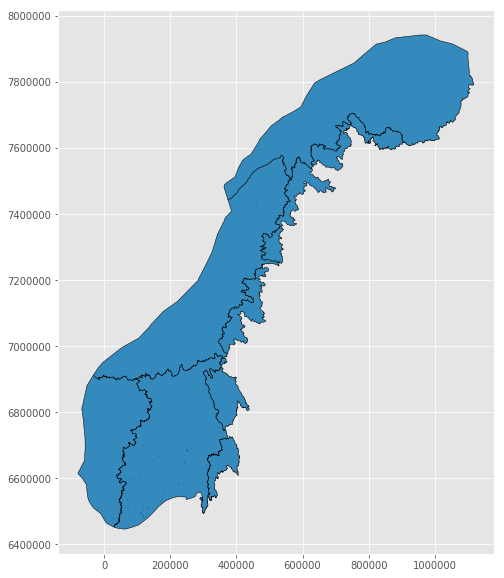

In [14]:
# Plot OSPAR regions
osp_gdf.to_crs({'init':'epsg:32633'}).plot(edgecolor='black', figsize=(10,10))

## 10. Assign EMEP grid cells to OSPAR regions

Each EMEP grid cell should be assigned to **just one** OSPAR region. To do this, I'll assign the OSPAR region that contains the **centre** of each grid cell.

In [15]:
# Assign EMEP celss to OSPAR regions
emep_gdf = nivapy.spatial.identify_point_in_polygon(emep_gdf,
                                                    out_json,
                                                    'index',
                                                    'ospar_regi',
                                                    'lat',
                                                    'lon')   

# Some cell centres lie outside OSPAR regions. Drop these
emep_gdf = emep_gdf.dropna(subset=['ospar_regi'])

emep_gdf.head()

,index,geometry,lon,lat,area,frac_area,total_dry_g,total_wet_g,total_dep_g,ospar_regi
3,3,"POLYGON ((6.700000000199907 58.00000000019992,...",6.65,58.05,65.769437,17.089623,68.751765,160.231505,228.983269,NORTH SEA
4,4,"POLYGON ((6.800000000000068 58.00000000019992,...",6.75,58.05,65.769437,22.975351,92.430122,215.415816,307.845938,NORTH SEA
5,5,"POLYGON ((6.899999999800173 58.00000000019992,...",6.85,58.05,65.769437,17.771160,81.445259,174.278069,255.723328,NORTH SEA
6,6,"POLYGON ((7.000000000499654 58.00000000019992,...",6.95,58.05,65.769438,30.233520,138.560278,296.493842,435.054120,NORTH SEA
7,7,"POLYGON ((7.100000000299815 58.00000000019992,...",7.05,58.05,65.769437,49.901470,290.821454,556.005789,846.827243,NORTH SEA


## 11. Merge cells to OSPAR regions

In [16]:
# Dissolve, summing deposition and frac_area
emep_gdf = emep_gdf.dissolve(by='ospar_regi', aggfunc='sum')

emep_gdf

,geometry,index,lon,lat,area,frac_area,total_dry_g,total_wet_g,total_dep_g
ospar_regi,,,,,,,,,
LOFOTEN-BARENTS SEA,(POLYGON ((24.89999999980023 68.49999999990013...,14173739,54569.70,167348.60,104298.854515,82164.911734,142966.202074,588828.097960,731794.300034
N/A,(POLYGON ((12.29999999980021 60.99999999960033...,1136040,5098.90,22750.10,19458.012153,13996.819965,23698.176870,82449.061854,106147.238724
NORTH SEA,"POLYGON ((6.700000000199907 58.00000000019992,...",1144960,5677.95,54243.05,55312.179918,47034.201473,95685.602564,493229.787622,588915.390186
NORWEGIAN SEA2,(POLYGON ((13.30000000049967 64.19999999950045...,6529502,20651.80,115307.70,95423.713729,80983.151759,132471.627560,770509.652915,902981.280475
SKAGERAK,(POLYGON ((11.60000000029981 62.19999999990011...,2262546,15864.70,99725.10,101199.697692,98695.040479,193768.228001,552955.232537,746723.460538


## 12. Calculate fluxes

In [17]:
# Divide dep by region area
for dep in ['total_dry', 'total_wet', 'total_dep']:
    emep_gdf['%s_flux_g/km2' % dep] = emep_gdf['%s_g' % dep] / emep_gdf['frac_area']

emep_gdf

,geometry,index,lon,lat,area,frac_area,total_dry_g,total_wet_g,total_dep_g,total_dry_flux_g/km2,total_wet_flux_g/km2,total_dep_flux_g/km2
ospar_regi,,,,,,,,,,,,
LOFOTEN-BARENTS SEA,(POLYGON ((24.89999999980023 68.49999999990013...,14173739,54569.70,167348.60,104298.854515,82164.911734,142966.202074,588828.097960,731794.300034,1.739991,7.166418,8.906409
N/A,(POLYGON ((12.29999999980021 60.99999999960033...,1136040,5098.90,22750.10,19458.012153,13996.819965,23698.176870,82449.061854,106147.238724,1.693112,5.890557,7.583668
NORTH SEA,"POLYGON ((6.700000000199907 58.00000000019992,...",1144960,5677.95,54243.05,55312.179918,47034.201473,95685.602564,493229.787622,588915.390186,2.034383,10.486620,12.521003
NORWEGIAN SEA2,(POLYGON ((13.30000000049967 64.19999999950045...,6529502,20651.80,115307.70,95423.713729,80983.151759,132471.627560,770509.652915,902981.280475,1.635792,9.514444,11.150236
SKAGERAK,(POLYGON ((11.60000000029981 62.19999999990011...,2262546,15864.70,99725.10,101199.697692,98695.040479,193768.228001,552955.232537,746723.460538,1.963303,5.602665,7.565967


## 13. Plot

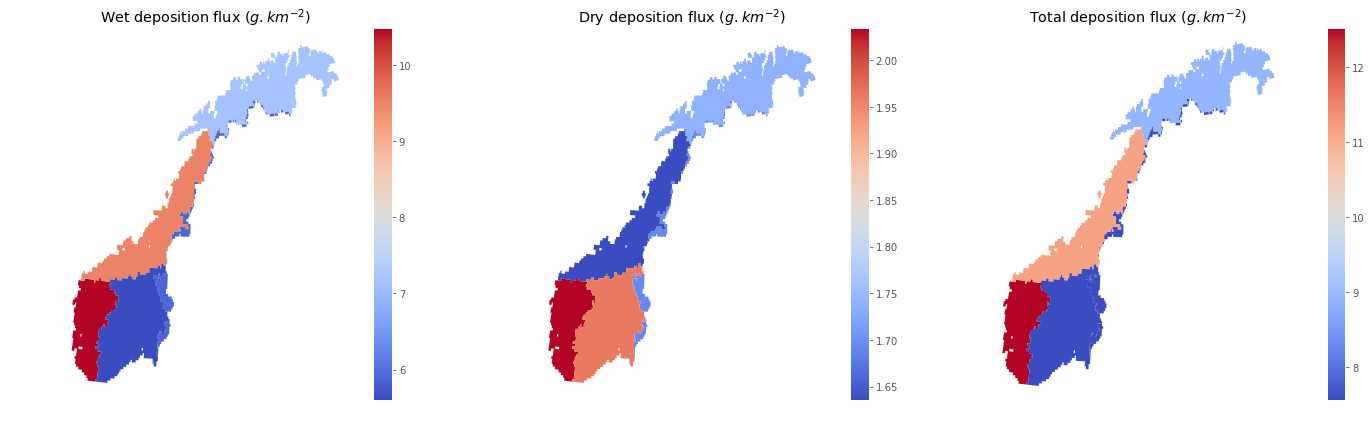

In [18]:
# Project to UTM Z33N
gdf = emep_gdf.to_crs({'init':'epsg:32633'})

# Setup plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

# Plot wet
gdf.plot(column='total_wet_flux_g/km2', 
         cmap='coolwarm',
      #   scheme='quantiles',
         legend=True,
         legend_kwds={'loc':'upper left'},
         ax=axes[0]) 
axes[0].set_title('Wet deposition flux ($g.km^{-2}$)')

# Plot dry
gdf.plot(column='total_dry_flux_g/km2',
         cmap='coolwarm',
      #   scheme='quantiles',
         legend=True,
         legend_kwds={'loc':'upper left'},
         ax=axes[1]) 
axes[1].set_title('Dry deposition flux ($g.km^{-2}$)')

# Plot total
gdf.plot(column='total_dep_flux_g/km2', 
         cmap='coolwarm',
      #   scheme='equal_interval',
         legend=True,
         legend_kwds={'loc':'upper left'},
         ax=axes[2]) 
axes[2].set_title('Total deposition flux ($g.km^{-2}$)')

# Turn off axes
for ax in axes:
    ax.set_axis_off()
plt.axis('equal')
plt.tight_layout()

# Save figure
png_path = r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep\png\norway_hg_dep_2016.png'
plt.savefig(png_path, dpi=300)

## 14. Save

In [19]:
# Save as geojson
out_json = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
            r'\data\gis\emep_hg_dep.geojson')
emep_gdf.to_file(out_json, driver='GeoJSON')

In [20]:
# Save as CSV
out_csv = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\EMEP_Hg_Dep'
           r'\data\emep_hg_dep.csv')
df = pd.DataFrame(emep_gdf).copy()
del df['geometry']
df.to_csv(out_csv)